# MRT puzzle

The MRT puzzle is the second in the NUS Math Society Puzzle Series, designed by me. A graph theory problem at heart, this puzzle asks for Hamiltonian paths satisfying certain criteria. Namely, that all non-LRT lines must be ridden exactly 3 distinct times. The passage below is the puzzle created.

### The puzzle

Your train-loving friend is travelling to Singapore for the first time and wants to visit all the MRT interchanges (shown in the picture). However, he does not want to visit or pass through any station more than once. Furthermore, he wants to take each non-LRT (non-grey) train line <font color=red>exactly 3 distinct times</font> during the journey. Can you help plan his route?

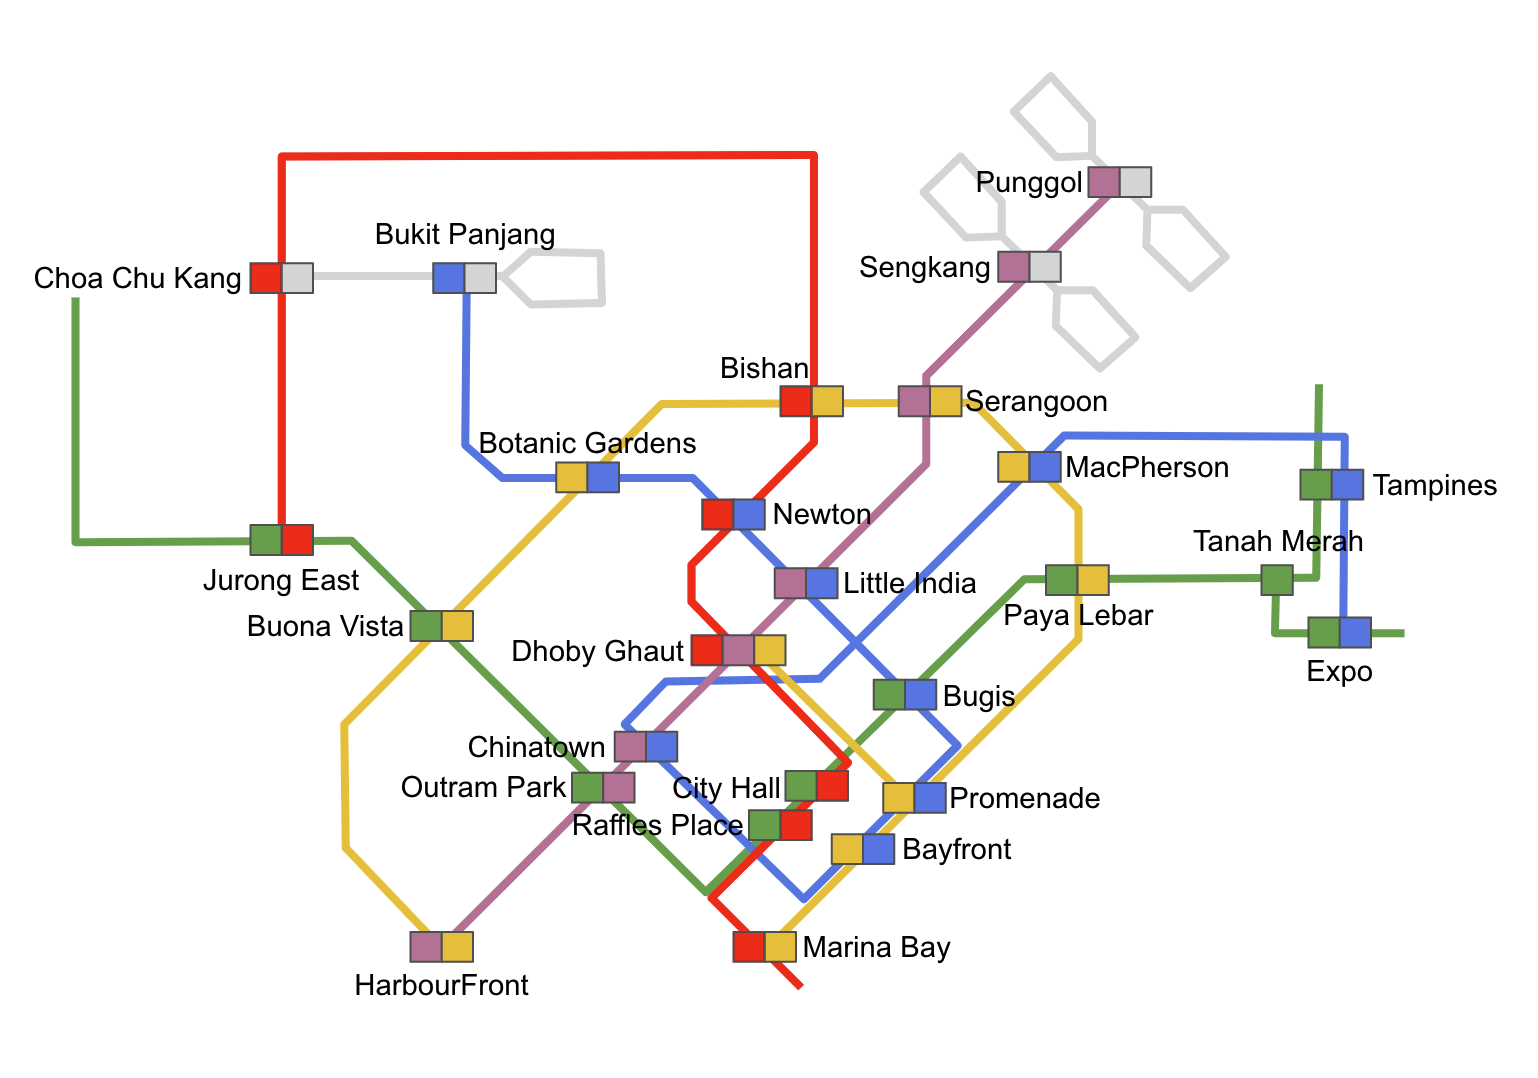

#### Assumptions:

You may only use the network and stations shown in the picture.
Two uses of the same line are considered distinct if they are separated by the use of another line.
The extensions to the Green and Yellow line connect to their main lines at Tanah Merah and Promenade respectively (i.e. it is impossible to travel from Bayfront to Dhoby Ghaut on the Yellow line without first passing through Promenade). Furthermore, Bedok to Tanah Merah to Expo constitutes one usage of the Green line.

## Importing packages
The code below simply imports all the packages I need for analysis.

In [ ]:
import collections
from wilcoxon import sheets
import re
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import geoplot
import contextily as ctx
from shapely import wkt
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## Creating the graph
The code below is used to create the edges of the graph. The edges come in the form `[START_NODE, END_NODE, LINE_USED]` and its direction doesn't matter. I've saved everything as a variable to make it easier to manually key in the edges.

In [23]:
JE = "Jurong East"
CCK = "Choa Chu Kang"
BP = "Bukit Panjang"
BG = "Botanic Gardens"
BI = "Bishan"
SR = "Serangoon"
SK = "Sengkang"
PG = "Punggol"
TP = "Tampines"
EX = "Expo"
TM = "Tanah Merah"
PL = "Paya Lebar"
BU = "Bugis"
PR = "Promenade"
BF = "Bayfront"
MB = "Marina Bay"
RP = "Raffles Place"
CH = "City Hall"
DG = "Dhoby Ghaut"
CT = "Chinatown"
OP = "Outram Park"
HF = "HarbourFront"
BV = "Buona Vista"
NT = "Newton"
LI = "Little India"
MP = "MacPherson"
WD = "Woodlands"
BH = "Bright Hill"
CC = "Caldecott"
ST = "Stevens"
OC = "Orchard"
SB = "Sungei Bedok"
PA = "Pasir Ris"
HG = "Hougang"
AMK = "Ang Mo Kio"
TG = "Tengah"
BJ = "Bahar Junction"
BL = "Boon Lay"

NSL = "NSL" 
EWL = "EWL" 
NEL = "NEL" 
CCL = "CCL" 
DTL = "DTL" 
LRT = "LRT"
TEL = "TEL"
CRL = "CRL"
JRL = "JRL"

L = [JE,CCK,NSL,
    CCK,BP,LRT,
    CCK,BI,NSL,
    BI,NT,NSL,
    NT,DG,NSL,
    DG,CH,NSL,
    CH,RP,NSL,
    RP,MB,NSL,
    BP,BG,DTL,
    BG,NT,DTL,
    NT,LI,DTL,
    LI,BU,DTL,
    BU,PR,DTL,
    PR,BF,DTL,
    BF,CT,DTL,
    CT,MP,DTL,
    MP,TP,DTL,
    TP,EX,DTL,
    TP,TM,EWL,
    TM,EX,EWL,
    TM,PL,EWL,
    PL,BU,EWL,
    BU,CH,EWL,
    CH,RP,EWL,
    RP,OP,EWL,
    OP,BV,EWL,
    BV,JE,EWL,
    HF,OP,NEL,
    OP,CT,NEL,
    CT,DG,NEL,
    DG,LI,NEL,
    LI,SR,NEL,
    SR,SK,NEL,
    SK,PG,NEL,
    HF,BV,CCL,
    BV,BG,CCL,
    BG,BI,CCL,
    BI,SR,CCL,
    SR,MP,CCL,
    MP,PL,CCL,
    PL,PR,CCL,
    PR,BF,CCL,
    BF,MB,CCL,
    PR,DG,CCL]

This code was created when extending the problem to include the Thomson East Coast Line (`TEL`), which has simply too many paths to enumerate in time.

In [24]:
# L = [CCK,BP,LRT,JE,CCK,NSL,CCK,WD,NSL,WD,AMK,NSL,AMK,BI,NSL,BI,NT,NSL,NT,OC,NSL,OC,DG,NSL,DG,CH,NSL,CH,RP,NSL,RP,MB,NSL,BP,BG,DTL,BG,ST,DTL,ST,NT,DTL,NT,LI,DTL,LI,BU,DTL,BU,PR,DTL,PR,BF,DTL,BF,CT,DTL,CT,MP,DTL,MP,TP,DTL,TP,EX,DTL,EX,SB,DTL,PA,TP,EWL,TP,TM,EWL,TM,EX,EWL,TM,PL,EWL,PL,BU,EWL,BU,CH,EWL,CH,RP,EWL,RP,OP,EWL,OP,BV,EWL,BV,JE,EWL,JE,BL,EWL,HF,OP,NEL,OP,CT,NEL,CT,DG,NEL,DG,LI,NEL,LI,SR,NEL,SR,HG,NEL,HG,SK,NEL,SK,PG,NEL,HF,BV,CCL,BV,BG,CCL,BG,CC,CCL,CC,BI,CCL,BI,SR,CCL,SR,MP,CCL,MP,PL,CCL,PL,PR,CCL,PR,BF,CCL,BF,MB,CCL,MB,HF,CCL,PR,DG,CCL,WD,BH,TEL,BH,CC,TEL,CC,ST,TEL,ST,OC,TEL,OC,OP,TEL,OP,MB,TEL,MB,SB,TEL,PA,HG,CRL,HG,AMK,CRL,AMK,BH,CRL,BL,BJ,JRL,BJ,TG,JRL,TG,CCK,JRL,JE,TG,JRL]

This code just operates on the list such that 3 consecutive elements are grouped into the same sublist. The list `stations` now contains all the stations involved in the list.

In [25]:
L = [(L[3*i:3*i+3]) for i in range(int(len(L)/3))]
stations = list(set([item for sublist in [[x[0],x[1]] for x in L] for item in sublist]))
stations[:5]

['Tanah Merah', 'Sengkang', 'Bishan', 'Little India', 'Newton']

`LTEL` and `stationsTEL` were used for the `TEL` case, corresponding to `L` and `stations` respectively.

In [2]:
# LTEL = [x for x in L if not any(item in x for item in ["JRL","CRL","Pasir Ris","Boon Lay"])]
# stationsTEL = list(set([item for sublist in [[x[0],x[1]] for x in LTEL] for item in sublist]))

## Outputting the paths
Once the edges have been set up, it is time to generate all the possible paths. First, we start by observing that all paths terminate or start at Punggol, since there is only one way in and out of it. Without loss of generality, we can assume that all paths start at Punggol. With that, we can set up a recursive function `paths()`, which takes the current edges still available to us, the stations we still haven't visited, as well as our current position in the graph.<br><br>At every step of the recursive process, we find all possible edges that connect to our current position (`possible`). We can then manipulate these edges, removing our current position from each of them so that only the destinations remain (`ignoreStation`). Then, from the current set of edges, we remove those that connect to our current position (`newConnections`). We shall do the same to the current set of stations, removing our current position from that set (`newStations`).<br><br>We can then loop through the possible edges, each time calling the `paths()` function again, but this time with the new set of edges and stations. We shall attach our current station to the start of this result set. Each path would end either when all the stations are used up, or when a station has no more valid connections. By means of wishful thinking, we are able to loop through all the possible paths starting from Punggol.

In [28]:
def paths(l, s, start):
    if len(l) == 0 or len(s) == 0:
        return [[start]]
    else:
        possible = [x for x in l if start in x]
        ignoreStation = [[y for y in x if y != start] for x in possible]
        newConnections = [x for x in l if x not in possible]
        newStations = [x for x in s if x != start]
        if len(ignoreStation) == 0:
            return [[start]]
        else:
            options = []
            for chosen in ignoreStation:
                options.extend([[start,chosen[1]] + x for x in paths(newConnections, newStations, chosen[0])])
            return options

res = paths(L, stations, PG)

res[0][:7]

['Punggol', 'NEL', 'Sengkang', 'NEL', 'Serangoon', 'NEL', 'Little India']

## Check whether path is Hamiltonian
This code checks whether the path passes through all the stations and only returns those with complete paths (`reachesAll`). Do note the `reachesAllTEL` version to this as well.

In [10]:
reachesAll = [x for x in res if len(x) == 2*len(stations) - 1]
# reachesAllTEL = [x for x in res if len(x) == 2*len(stationsTEL) - 1]
len(reachesAll)

634

## Checking validity of solution
Here we check whether the solution is valid, based on our criteria. But first, we'll need to parse the paths that we got from the function `paths()`.<br><br>The results are stored as instructions such that the path from Bugis to Paya Lebar to MacPherson is recorded as `["Bugis","EWL","Paya Lebar","CCL","MacPherson"]`. We can do a few things with this. Firstly, we can extract out all of the stations (`stationsOrder`) and lines (`linesOrder`). Next, we can condense `linesOrder` into `condensedLinesOrder` such that no two adjacent entries are the same, as in `["EWL","CCL","CCL","NSL"]` is converted to `["EWL","CCL","NSL"]`. Then, with the help of the `collections` library, we can find out the number of times each line is used, sorted by number of uses (`usages`).
#### Checking for success
Now we can create our conditions for success. As you can see below, I've come up with several different criteria for success:
1. `collections.Counter(condensedLinesOrder)["DTL"] > 4` checks whether the Downtown Line was used more than 4 times.
2. `usages[0][1] == 3 and usages[-1][1] == 3` checks whether each non-LRT line was used exactly 3 times (the conditions to our original problem).
3. `sum(collections.Counter(condensedLinesOrder).values()) > 20` checks whether the total number of line changes is at least 20.
4. `True` just returns all of the results as solutions.

As usual, do note the `solutionsTEL` for the TEL version of this problem.

#### Additional data
1. `noLRT` - checks whether "LRT" was not used in the path.
2. `solutionList` - cleans up the results to be easy to present.
3. `mostCommonPoint` - sorts the edges which are most used in the paths.


In [32]:
solutions = []
for potentialSolution in reachesAll:    
    stationsOrder = [potentialSolution[2*i] for i in range(len(stations))]
    linesOrder = [potentialSolution[2*i+1] for i in range(len(stations)-1)]
    condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
    usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
    # success = collections.Counter(condensedLinesOrder)["DTL"] < 4
    # success = usages[0][1] == 3 and usages[-1][1] == 3
    # success = sum(collections.Counter(condensedLinesOrder).values()) > 20
    success = True
    if success: solutions.append(list(zip(stationsOrder, linesOrder+["END"])))
        
# solutionsTEL = []
# for potentialSolution in reachesAllTEL:    
#     stationsOrder = [potentialSolution[2*i] for i in range(len(stationsTEL))]
#     linesOrder = [potentialSolution[2*i+1] for i in range(len(stationsTEL)-1)]
#     condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
#     usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
#     success = usages[0][1] == 3 and usages[-1][1] != 3
#     if success: solutionsTEL.append(list(zip(stationsOrder, linesOrder+["END"])))

noLRT = [z[0] for z in list(zip(solutions, ["LRT" in [y[1] for y in x] for x in solutions])) if not z[1]]

solutionList = []
for x in solutions:
    m=[]
    for y in x:
        m+=list(y)
    solutionList.append(m)

mostCommonPoint = collections.Counter([item for sublist in solutions for item in sublist]).most_common()
        

## Retrieving MRT data
This section of the code seeks to merge our results set with the actual locations of the MRT, so that we can plot the paths. This chunk basically retrieves the MRT data that's found in my Google Sheets, converting them into dictionaries, based on its name (`nameIndex`) and its labels (`labelIndex`). I also manually adjusted some of the entries, namely Tanah Merah and Promenade.

In [241]:
mrt = sheets.getGeo("MRT")

nameIndex = mrt.set_index("Name").to_dict("index")
mrt["Label List"] = mrt.Label.str.split(", ")
mrt = mrt.explode("Label List")
mrt.drop_duplicates(inplace=True, subset=["Label List"])
labelIndex = mrt.set_index("Label List").to_dict("index")

nameIndex["Tanah Merah"]["Label"] = "EW4, CG0"
nameIndex["Promenade"]["Label"] = "CC4, DT15, CE0"

## The preparation
The main purpose of this process is to add the coordinates of all the interchanges as well as the intermediate stations like Eunos etc.<br><br>This code loops through the solutions and does quite a number of things. First it manipulates the edges to re-include the destination station (`connnection`). More specifically, each element in the list combines with its successor. Secondly, the code determines the abbreviation of the line like `"NS"` for the North South Line and `"EW"` for the East West Line (`lineAbbr`), making minor adjustments wherever necessary. Next, based on the dictionary mapping from earlier, we can extract out the labels for the start and end positions (`startLabel`, `endLabel`). We can further extract their numerical values, so `"NS14"` becomes `14` etc.. After a bunch of standardisation, we can find the numerical value for the start and end positions. From these two numbers, we can generate the numbers in between, which represent the other stations we pass through (`betweenNumbers`). This can be further manipulated to re-attach `lineAbbr`, to form `betweenLabels` and we combine everything together (`currentLabels`).<br><br>After we have all our stations, we do some minor filters and mappings, until we have our list of station labels (`mappedLabels`). Using the `labelIndex`, we can map all our station labels into coordinates. From there, we can prepare our data for the GeoDataFrame. We convert this list of coordinates into the `shapely.geometry.LineString` object, which accepts a list of points as its argument. This is what we'll eventually feed into the GeoDataFrame (`G`). We add the names of the stations and we're pretty much done with preparation.

In [51]:
G = []
for solution in solutions:

    currentLabels = []
    for i in range(len(solution)-1):
        connection = solution[i] + (solution[i+1][0],)
        lineAbbr = connection[1][:-1]
        if lineAbbr == "LR": lineAbbr = "BP"
        if "Expo" in connection and lineAbbr == "EW": lineAbbr = "CG"
        if "Bayfront" in connection and ("Promenade" in connection or "Marina Bay" in connection) and lineAbbr == "CC": lineAbbr = "CE"
        startLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[0]]["Label"]).group()[2:])
        endLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[2]]["Label"]).group()[2:])
        betweenNumbers = [i for i in range(min(startLabel, endLabel), max(startLabel, endLabel) + 1)]
        if betweenNumbers[0] != startLabel:
            betweenNumbers.reverse()
        betweenLabels = [lineAbbr + str(x) for x in betweenNumbers]
        if i == 0: currentLabels.extend(betweenLabels)
        else: currentLabels.extend(betweenLabels[1:])

    filteredLabels = [x for x in currentLabels if not any([x in item for item in ["NE2"]])]
    mappedLabels = "||".join(filteredLabels).replace("CG0","EW4").replace("CE0","CC4").split("||")
    mappedLabels = [x for x in mappedLabels if not math.isnan(labelIndex[x]["Lat"])]

    G.append([solution, ", ".join([labelIndex[x]["Name"] for x in mappedLabels]), LineString([Point(labelIndex[x]["Long"], labelIndex[x]["Lat"]) for x in mappedLabels])])

## Visualisation
So this is the final section, where we can see the different paths taken. Our current data is passed as a `pandas.DataFrame` object and then as a `geopandas.GeoDataFrame` object, where we can then plot and add the basemap using Contextily.

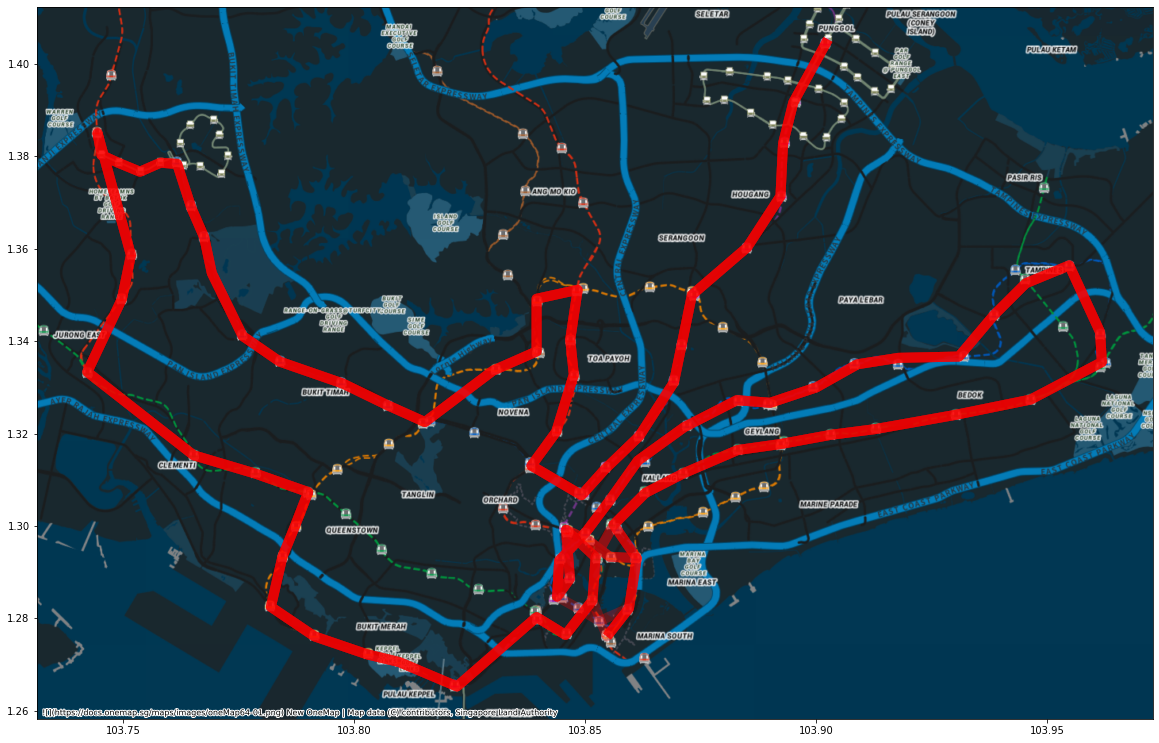

In [52]:
G = gpd.GeoDataFrame(pd.DataFrame(G, columns = ["Solution", "Path", "geometry"]), geometry="geometry")
ax = G.geometry.iloc[:6].plot(figsize=(20,20), edgecolor="red", linewidth=10, alpha = 0.3)
ctx.add_basemap(ax, zoom=13, crs="EPSG:4326", source=ctx.providers.OneMapSG.Night)

## Ending note
Do try out different criteria for valid solutions! There are some pretty interesting ones out there!
### There are 22 distinct uses of lines in total (maximum number possible)


6 solutions found
Punggol NEL Sengkang NEL Serangoon CCL MacPherson DTL Chinatown DTL Bayfront CCL Marina Bay NSL Raffles Place EWL Outram Park NEL HarbourFront CCL Buona Vista EWL Jurong East NSL Choa Chu Kang LRT Bukit Panjang DTL Botanic Gardens CCL Bishan NSL Newton DTL Little India NEL Dhoby Ghaut NSL City Hall EWL Bugis DTL Promenade CCL Paya Lebar EWL Tanah Merah EWL Tampines DTL Expo END


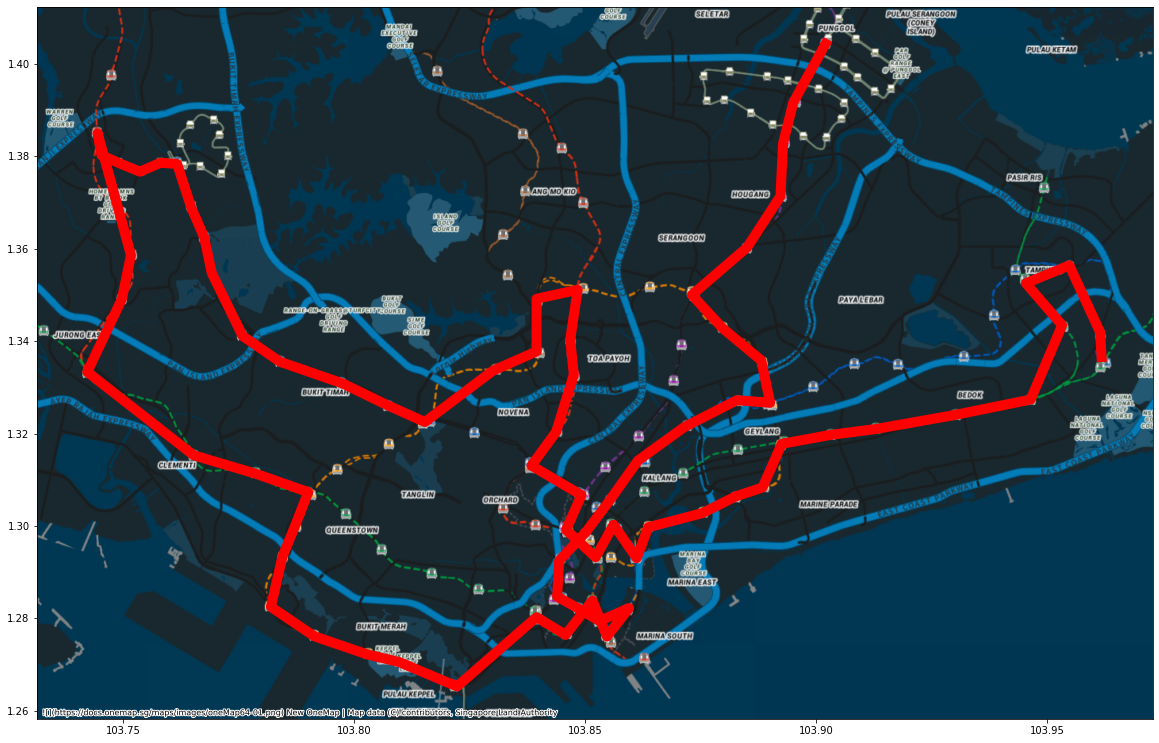

In [75]:
solutions = []
for potentialSolution in reachesAll:    
    stationsOrder = [potentialSolution[2*i] for i in range(len(stations))]
    linesOrder = [potentialSolution[2*i+1] for i in range(len(stations)-1)]
    condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
    usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
    success = sum(collections.Counter(condensedLinesOrder).values()) == 22
    if success: solutions.append(list(zip(stationsOrder, linesOrder+["END"])))
        
def getG(s):
    G = []
    for solution in solutions:

        currentLabels = []
        for i in range(len(solution)-1):
            connection = solution[i] + (solution[i+1][0],)
            lineAbbr = connection[1][:-1]
            if lineAbbr == "LR": lineAbbr = "BP"
            if "Expo" in connection and lineAbbr == "EW": lineAbbr = "CG"
            if "Bayfront" in connection and ("Promenade" in connection or "Marina Bay" in connection) and lineAbbr == "CC": lineAbbr = "CE"
            startLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[0]]["Label"]).group()[2:])
            endLabel = int(re.compile(f"{lineAbbr}\d+").search(nameIndex[connection[2]]["Label"]).group()[2:])
            betweenNumbers = [i for i in range(min(startLabel, endLabel), max(startLabel, endLabel) + 1)]
            if betweenNumbers[0] != startLabel:
                betweenNumbers.reverse()
            betweenLabels = [lineAbbr + str(x) for x in betweenNumbers]
            if i == 0: currentLabels.extend(betweenLabels)
            else: currentLabels.extend(betweenLabels[1:])

        filteredLabels = [x for x in currentLabels if not any([x in item for item in ["NE2"]])]
        mappedLabels = "||".join(filteredLabels).replace("CG0","EW4").replace("CE0","CC4").split("||")
        mappedLabels = [x for x in mappedLabels if not math.isnan(labelIndex[x]["Lat"])]

        G.append([solution, ", ".join([labelIndex[x]["Name"] for x in mappedLabels]), LineString([Point(labelIndex[x]["Long"], labelIndex[x]["Lat"]) for x in mappedLabels])])
    return G

G = getG(solutions)

G = gpd.GeoDataFrame(pd.DataFrame(G, columns = ["Solution", "Path", "geometry"]), geometry="geometry")
ax = G.geometry.iloc[:1].plot(figsize=(20,20), edgecolor="red", linewidth=10, alpha = 1)
ctx.add_basemap(ax, zoom=13, crs="EPSG:4326", source=ctx.providers.OneMapSG.Night)
print(f"{len(solutions)} solutions found")
print(" ".join([item for sublist in G.iloc[0].Solution for item in sublist]))


### Each line is used exactly 2 times

2 solutions found
Punggol NEL Sengkang NEL Serangoon NEL Little India NEL Dhoby Ghaut CCL Promenade CCL Bayfront CCL Marina Bay NSL Raffles Place NSL City Hall EWL Bugis EWL Paya Lebar EWL Tanah Merah EWL Expo DTL Tampines DTL MacPherson DTL Chinatown NEL Outram Park NEL HarbourFront CCL Buona Vista EWL Jurong East NSL Choa Chu Kang NSL Bishan NSL Newton DTL Botanic Gardens DTL Bukit Panjang END


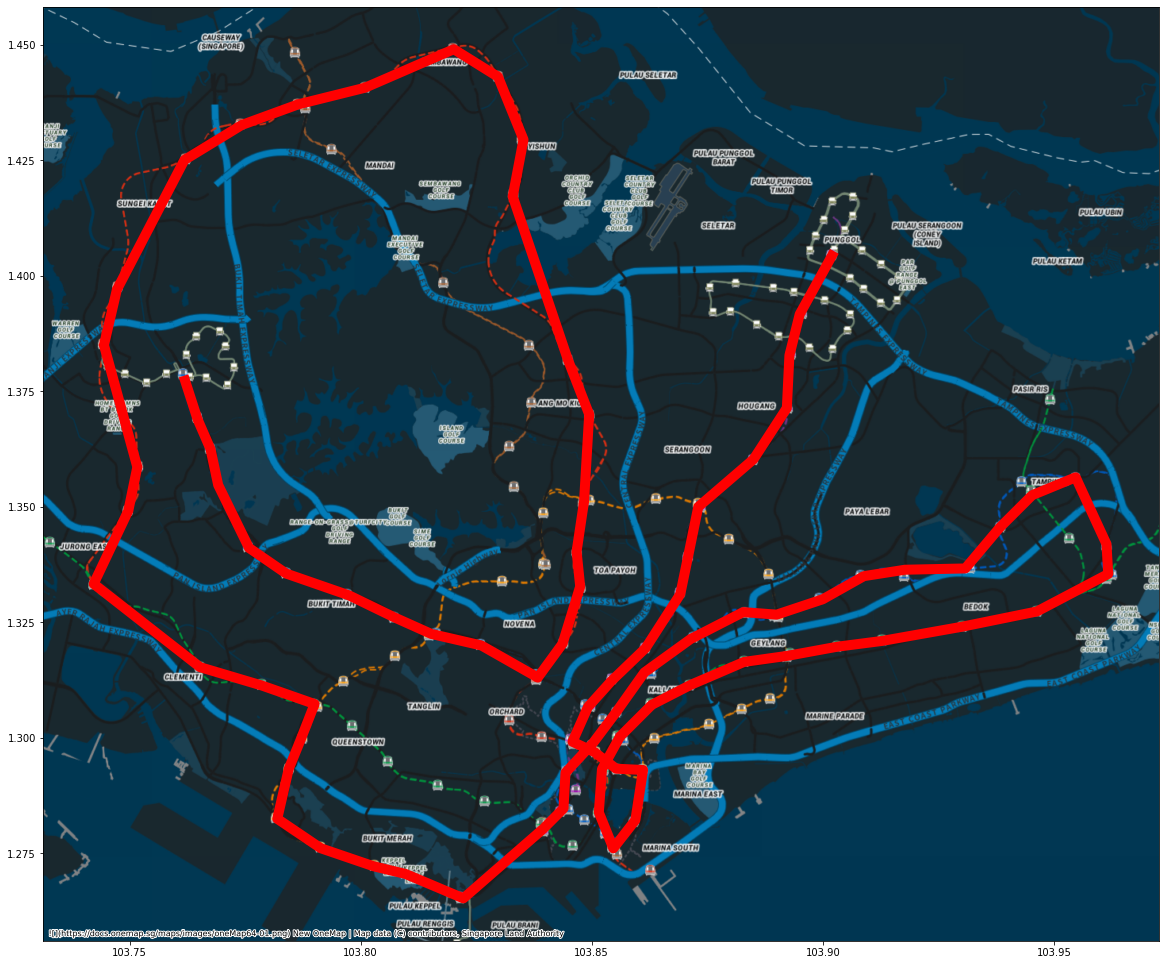

In [76]:
solutions = []
for potentialSolution in reachesAll:    
    stationsOrder = [potentialSolution[2*i] for i in range(len(stations))]
    linesOrder = [potentialSolution[2*i+1] for i in range(len(stations)-1)]
    condensedLinesOrder = [linesOrder[i] for i in range(len(linesOrder)-1) if linesOrder[i] != linesOrder[i+1]] + [linesOrder[-1]]
    usages = [x for x in collections.Counter(condensedLinesOrder).most_common() if x[0] != "LRT"]
    success = usages[0][1] == 2 and usages[-1][1] == 2
    if success: solutions.append(list(zip(stationsOrder, linesOrder+["END"])))

G = getG(solutions)

G = gpd.GeoDataFrame(pd.DataFrame(G, columns = ["Solution", "Path", "geometry"]), geometry="geometry")
ax = G.geometry.iloc[:1].plot(figsize=(20,20), edgecolor="red", linewidth=10, alpha = 1)
ctx.add_basemap(ax, zoom=13, crs="EPSG:4326", source=ctx.providers.OneMapSG.Night)
print(f"{len(solutions)} solutions found")
print(" ".join([item for sublist in G.iloc[0].Solution for item in sublist]))
        